In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import pyproj
from shapely.geometry import Polygon

In [3]:
data = pd.read_csv('Data/kody_stacji.csv', encoding='windows-1250',delimiter=";")    
#Zwykłe kodowanie utf-8 nie działało --> po otwarciu pliku w Excelu można sprawdzić rodzaj kodowania 
data = data.set_index('LP.')   #ustawiam indeks 
data

,ID,Nazwa,Rzeka,Szerokość geograficzna,Długość geograficzna,Wysokość n.p.m.
LP.,,,,,,
1,250180590,RYBNIK-STODOŁY,Ruda,50 09 16,18 28 59,216
2,254140010,DZIWNÓW,NaN,54 01 20,14 43 54,7
3,250160530,ZIELENIEC,Bystrzyca Dusznicka,50 19 48,16 23 39,840
4,250160630,MIĘDZYGÓRZE,Wilczka,50 13 06,16 46 23,800
5,250160650,MIĘDZYLESIE,Nysa Kłodzka,50 09 12,16 40 15,453
...,...,...,...,...,...,...
637,250140020,SIENIAWKA,Nysa Łużycka,50 53 38,14 50 08,234
638,250160920,PIŁAWA GÓRNA,Piława,50 41 22,16 43 57,295
639,249180590,RUPTAWA,Olza,49 56 12,18 35 22,230


C:\Users\Zuzia\AppData\Local\Temp\ipykernel_21164\2322248491.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  poland = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


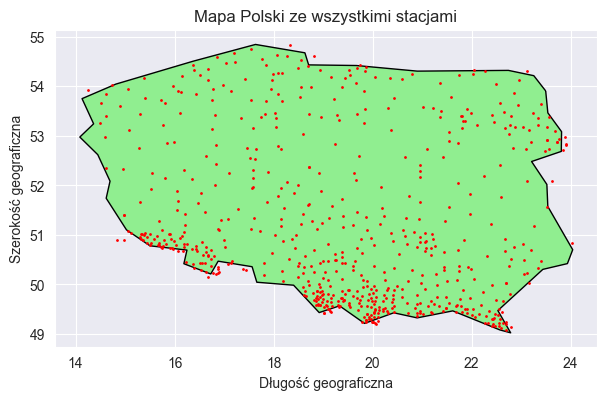

In [4]:
# Funkcja do konwersji współrzędnych na obiekty Shapely Point
def convert_to_point(row):
    lat, lon = row['Szerokość geograficzna'], row['Długość geograficzna']
    lat_deg, lat_min, lat_sec = map(float, lat.split())
    lon_deg, lon_min, lon_sec = map(float, lon.split())
    latitude = lat_deg + lat_min / 60 + lat_sec / 3600
    longitude = lon_deg + lon_min / 60 + lon_sec / 3600
    return Point(longitude, latitude)

# Dodanie kolumny z obiektami Point
data['geometry'] = data.apply(convert_to_point, axis=1)

# Tworzenie ramki GeoPandas
data_gfd = gpd.GeoDataFrame(data, geometry='geometry')

# Wczytanie granic administracyjnych Polski
poland = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
poland = poland[poland.name == 'Poland']

# Tworzenie mapy
fig, ax = plt.subplots(figsize=(7, 5))
poland.plot(ax=ax, color='lightgreen', edgecolor='black')
data_gfd.plot(ax=ax, marker='o', color='red', markersize=1)
plt.title('Mapa Polski ze wszystkimi stacjami')
plt.xlabel('Długość geograficzna')
plt.ylabel('Szerokość geograficzna')
plt.show()

C:\Users\Zuzia\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


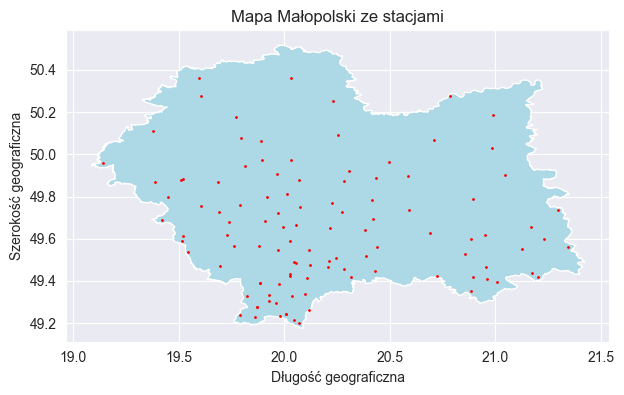

In [6]:

# Wczytaj granice Małopolski jako obiekt typu Polygon
granice_malopolski = gpd.read_file('Data/malopolska.shp')
polygon_epsg2180 = granice_malopolski.geometry.iloc[0]

# Utwórz transformator do przekształcania współrzędnych
transformer = pyproj.Transformer.from_crs("EPSG:2180", "EPSG:4326", always_xy=True)

# Przekształć współrzędne poligonu na współrzędne geograficzne
polygon_wgs84_coords = []
for x, y in polygon_epsg2180.exterior.coords:
    lon, lat = transformer.transform(x, y)
    polygon_wgs84_coords.append((lon, lat))

# Utwórz obiekt poligonu w formacie EPSG:4326 (współrzędne geograficzne)
polygon_wgs84 = Polygon(polygon_wgs84_coords)
# Utworzenie GeoDataFrame z pojedynczym wierszem zawierającym ten poligon
granice_malopolski = gpd.GeoDataFrame({'geometry': [polygon_wgs84]})

# Znajdź punkty wewnątrz granic Małopolski
punkty_wewnatrz_malopolski = gpd.sjoin(data_gfd, granice_malopolski, how="inner", op="within")

# Tworzenie mapy
fig, ax = plt.subplots(figsize=(7, 5))
# poland.plot(ax=ax, color='lightgreen', edgecolor='black')
granice_malopolski.plot(ax=ax,color="lightblue")
punkty_wewnatrz_malopolski.plot(ax=ax, marker='o', color='red', markersize=1)

plt.title('Mapa Małopolski ze stacjami')
plt.xlabel('Długość geograficzna')
plt.ylabel('Szerokość geograficzna')
plt.show()


## Wszystkie stacje pomiarowe w Małopolsce

In [7]:
punkty_wewnatrz_malopolski

,ID,Nazwa,Rzeka,Szerokość geograficzna,Długość geograficzna,Wysokość n.p.m.,geometry,index_right
LP.,,,,,,,,
42,249200220,ROZTOKA,Dunajec,49 38 25,20 23 00,815,POINT (20.38333 49.64028),0
43,249200240,PTASZKOWA,Łubinka,49 36 01,20 53 12,520,POINT (20.88667 49.60028),0
44,249200260,ŁĄCKO,Dunajec,49 33 35,20 26 22,366,POINT (20.43944 49.55972),0
45,249200270,TURBACZ,Raba,49 32 41,20 07 05,1 273,POINT (20.11806 49.54472),0
46,249200280,ŁABOWA,Kamienica,49 31 34,20 51 31,455,POINT (20.85861 49.52611),0
...,...,...,...,...,...,...,...,...
619,250190790,CHRZANÓW,NaN,50 06 45,19 22 36,251,POINT (19.37667 50.11250),0
622,249210370,ROPICA GÓRNA,NaN,49 35 46,21 13 53,356,POINT (21.23139 49.59611),0
623,249190980,SUCHA BESKIDZKA,NaN,49 45 14,19 36 21,324,POINT (19.60583 49.75389),0
